In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
import random
import pickle
import os.path as osp
import copy
import collections
import re

import pandas as pd

# HHblits

https://github.com/soedinglab/hh-suite/blob/ac765987bd0daceb093a41a8e2850887dad5835f/src/hhhit.h#L151

$\frac{p_{TP}(score)}{p_{TP}(score) + p_{FP}(score) } = \frac{1}{1 + (a \cdot \exp\frac{-score}{b} + c \cdot \exp\frac{-score}{d})^2}$

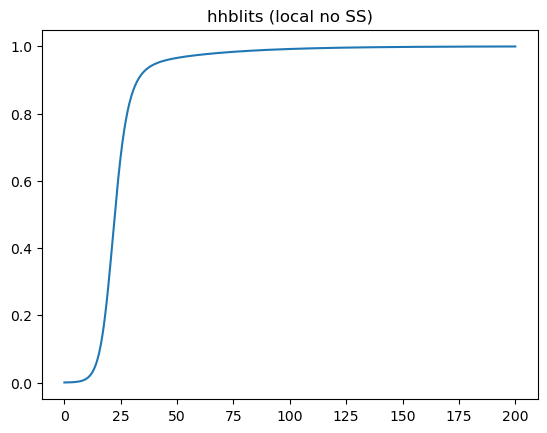

In [2]:
def hhblits_probab(s):
    a = np.sqrt(4000)
    b = 2 * 2.5
    c = np.sqrt(0.15)
    d = 2 * 34
    t = a * np.exp(-s / b) + c * np.exp(-s / d)
    
    return 1 / (1 + t**2)

x = np.linspace(0, 200, 1000)

plt.title('hhblits (local no SS)')
plt.plot(x, hhblits_probab(x))
plt.show()

# Fit the probabilty of true postives on "structure bits"

## Run Foldseek

In [3]:
%%bash --out output
mkdir -p out

FOLDSEEK=./foldseek/build/src/foldseek
$FOLDSEEK easy-search --sort-by-structure-bits 1 ../../../data/structur_align/pdbs/ ../../../data/structur_align/pdbs/ out/result.txt out/tmp -e 10

## Identify TP/FP

In [6]:
df = pd.read_csv('out/result.txt', delimiter='\t', names='qname,tname,tmscore,alnlen,ngaps,noidea,qstart,qend,tstart,tend,evalue,score'.split(','))
df = df.drop('ngaps,noidea,qstart,qend,tstart,tend'.split(','), axis=1)

In [7]:
sid2cl = {}
with open('../scopbenchmark/data/scop_lookup.fix.tsv') as file:
    for line in file:
        sid, cl = line.rstrip('\n').split()
        sid2cl[sid] = cl

In [8]:
scope_relation = collections.namedtuple('scope_relation', 'cls,fold,sfam,fam')

def same_scope_level(q, t):
    qcls, qfold, qsfam, qfam = q.split('.')
    tcls, tfold, tsfam, tfam = t.split('.')
    same_cls = qcls == tcls
    same_fold = same_cls and (int(qfold) == int(tfold))
    same_sfam = same_fold and (int(qsfam) == int(tsfam))
    same_fam = same_sfam and (int(qfam) == int(tfam))
    return scope_relation(same_cls, same_fold, same_sfam, same_fam)

In [9]:
df['q_scope'] = df.apply(lambda row: sid2cl[row['qname']], axis=1)
df['t_scope'] = df.apply(lambda row: sid2cl[row['tname']], axis=1)
df['same_sfam'] = df.apply(lambda row: same_scope_level(row['q_scope'], row['t_scope']).sfam, axis=1)
df['same_fold'] = df.apply(lambda row: same_scope_level(row['q_scope'], row['t_scope']).fold, axis=1)

In [10]:
pattern_rossman = re.compile('^c\.(2|3|4|5|27|28|30|31)\.[0-9]+\.[0-9]+')
df['rossman_hit'] = df.apply(lambda row: bool(pattern_rossman.match(row['q_scope'])) and bool(pattern_rossman.match(row['t_scope'])), axis=1)
pattern_bprob = re.compile('^b\.(66|67|68|69|70)\.[0-9]+\.[0-9]+')
df['bprob_hit'] = df.apply(lambda row: bool(pattern_bprob.match(row['q_scope'])) and bool(pattern_bprob.match(row['t_scope'])), axis=1)

In [11]:
tp = df[df['same_sfam']]
fp = df[(df['same_fold'] == False) & (df['rossman_hit'] == False) & (df['bprob_hit'] == False)]

tp.to_csv('out/tp_all.csv')
fp.to_csv('out/fp_all.csv')

In [12]:
fp[fp['score'] > 100].sort_values('score', ascending=False)

,qname,tname,tmscore,alnlen,evalue,score,q_scope,t_scope,same_sfam,same_fold,rossman_hit,bprob_hit
3135641,d2ag4a_,d1nepa_,0.161,160,8.832000e-08,193,b.95.1.1,b.1.18.7,False,False,False,False
387215,d1nepa_,d2ag4a_,0.161,160,1.768000e-07,180,b.1.18.7,b.95.1.1,False,False,False,False
3160641,d1v77a_,d3mkva2,0.128,193,9.039000e-07,175,c.6.3.2,c.1.9.18,False,False,False,False
3475549,d1naqa_,d2gx8a1,0.202,95,2.906000e-05,171,d.58.5.2,c.135.1.1,False,False,False,False
3507506,d2gx8a1,d4affa_,0.226,90,7.971000e-05,170,c.135.1.1,d.58.5.1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
419901,d1jw9b_,d1e5qa1,0.190,120,8.276000e-04,101,c.111.1.1,c.2.1.3,False,False,False,False
3299483,d1js1x2,d1sc6a1,0.111,142,2.880000e-04,101,c.78.1.1,c.2.1.4,False,False,False,False
3265048,d1y1pa1,d3d2la_,0.171,110,7.039000e-04,101,c.2.1.2,c.66.1.0,False,False,False,False
380275,d3tzqa_,d3doua_,0.180,130,8.333000e-04,101,c.2.1.0,c.66.1.0,False,False,False,False


## Visualize

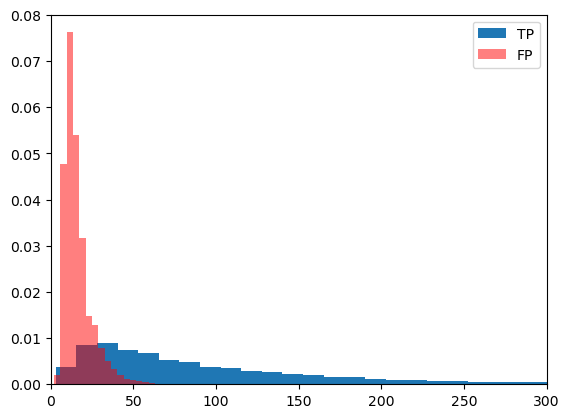

In [13]:
plt.hist(tp['score'], bins=1000, density=True, label='TP')
plt.hist(fp['score'], bins=50, density=True, color='red', alpha=0.5, label='FP')
plt.legend()
plt.xlim([0, 300])
plt.show()

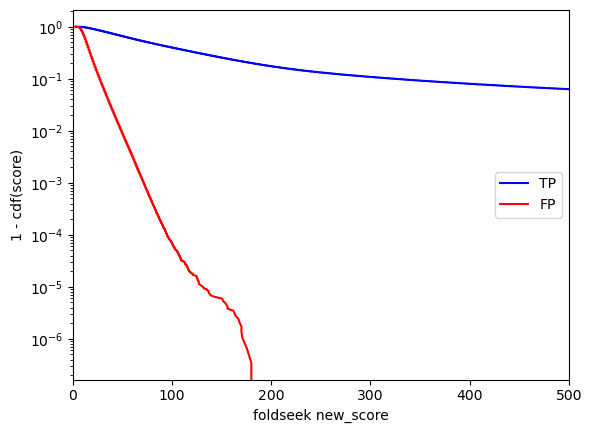

In [14]:
samples_tp = tp['score'].sort_values()
samples_fp = fp['score'].sort_values()
emp_cdf_tp = np.arange(1, len(samples_tp)+1)/len(samples_tp)
emp_cdf_fp = np.arange(1, len(samples_fp)+1)/len(samples_fp)

plt.plot(samples_tp, 1 - emp_cdf_tp, label='TP', color='blue')
plt.plot(samples_fp, 1 - emp_cdf_fp, label='FP', color='red')

plt.legend(loc=5)
plt.yscale('log')
plt.xlabel('foldseek new_score')
plt.ylabel('1 - cdf(score)')
plt.xlim([0, 500])
plt.show()

## Fit (R)

In [15]:
out = !~/anaconda3/envs/R/bin/Rscript fit.R out/tp_all.csv 10 2
comp_lam = list(map(float, out[-2].split()))
comp = np.array(list(map(float, out[-1].split()))).reshape(2, 2)
model_params_tp_e10 = [(comp_lam[i], comp[i][0], comp[i][1]) for i in range(2)]  # lambda, alpha, beta

In [16]:
out = !~/anaconda3/envs/R/bin/Rscript fit.R out/fp_all.csv 10 2
comp_lam = list(map(float, out[-2].split()))
comp = np.array(list(map(float, out[-1].split()))).reshape(2, 2)
model_params_fp_e10 = [(comp_lam[i], comp[i][0], comp[i][1]) for i in range(2)]  # lambda, alpha, beta

## Visualize fit

In [17]:
import scipy.stats

def gamma_mixture_pdf(x, params):
    arr = np.array([lam * scipy.stats.gamma.pdf(x, alpha, scale=beta) for lam, alpha, beta in params])
    return arr, arr.sum(axis=0)

def gamma_mixture_cdf(x, params):
    arr = np.array([lam * scipy.stats.gamma.cdf(x, alpha, scale=beta) for lam, alpha, beta in params])
    return arr.sum(axis=0)

In [18]:
def plot_hist_fit(df, evalue_threshold, label, color, bins, model_params, show_comp=False):
    plt.hist(df[df['evalue'] <= evalue_threshold]['score'], bins=bins, density=True, color=color, label=label, alpha=0.5)

    x = np.linspace(0, 1000, 1000)
    (comps), d = gamma_mixture_pdf(x, model_params)
    if show_comp:
        for c in comps:
            plt.plot(x, c, '--', color='gray', lw=1)
    plt.plot(x, d, color=color)
    
def plot_cdf_fit(df, evalue_threshold, label, color, model_params):
    samples = df[df['evalue'] <= evalue_threshold]['score'].sort_values()
    plt.plot(samples, 1 - np.arange(1, len(samples)+1)/len(samples), label=label, color=color, alpha=0.5)
    x = np.linspace(0, 1000, 2000)
    plt.plot(x, 1-gamma_mixture_cdf(x, model_params), '--', color=color, label=label, alpha=1)

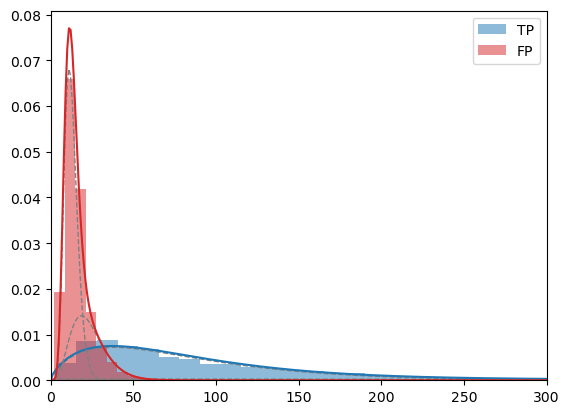

In [19]:
plot_hist_fit(tp, 10, 'TP', 'tab:blue', 1000, model_params_tp_e10, show_comp=True)
plot_hist_fit(fp, 10, 'FP', 'tab:red', 30, model_params_fp_e10, show_comp=True)

plt.legend()
plt.xlim([0, 300])
plt.show()

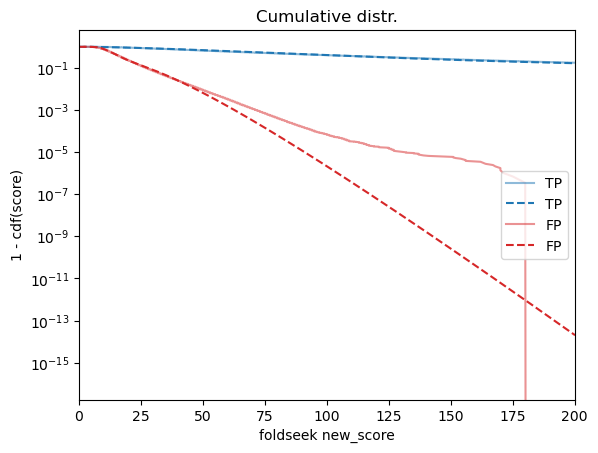

In [20]:
plot_cdf_fit(tp, 10, 'TP', 'tab:blue', model_params_tp_e10)
plot_cdf_fit(fp, 10, 'FP', 'tab:red', model_params_fp_e10)

plt.title('Cumulative distr.')
plt.legend(loc=5)
plt.yscale('log')
plt.xlabel('foldseek new_score')
plt.ylabel('1 - cdf(score)')
plt.xlim([0, 200])
plt.show()

## Prob. true positves

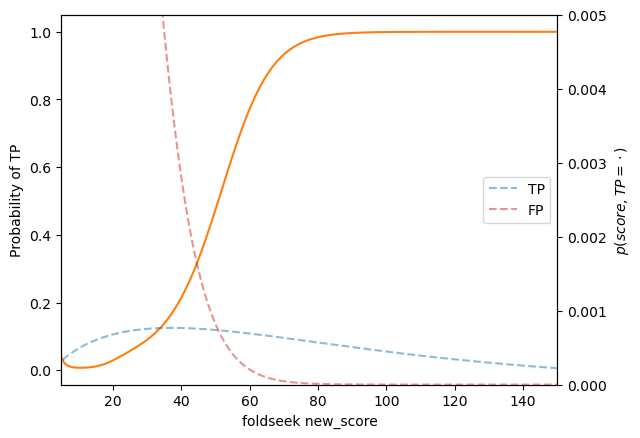

In [21]:
evalue_threshold = 10
n_tp = len(tp[tp['evalue'] <= evalue_threshold])
n_fp = len(fp[fp['evalue'] <= evalue_threshold])

x = np.linspace(1, 1000, 1000)
d_tp = gamma_mixture_pdf(x, model_params_tp_e10)[1] * (n_tp / (n_tp + n_fp))
d_fp = gamma_mixture_pdf(x, model_params_fp_e10)[1] * (n_fp / (n_tp + n_fp))

plt.plot(x, 1/(1+d_fp / d_tp), '-', color='tab:orange')
plt.ylabel('Probability of TP')
#ax.set_ylabel('$P(TP=1|score) = \\frac{p(score, TP=1)}{p(score, TP=1) + p(score, TP=0)}$')

plt.xlabel('foldseek new_score')
plt.xlim([5, 150])

ax = plt.twinx()
ax.plot(x, d_tp, '--', color='tab:blue', label='TP', alpha=0.5)
ax.plot(x, d_fp, '--', color='tab:red', label='FP', alpha=0.5)
ax.set_ylabel('$p(score, TP=\cdot)$')
ax.set_ylim([0, 0.005])
ax.legend(loc=5)

plt.savefig('prob_TP.jpg', dpi=400)
plt.show()

In [22]:
def generate_code(name, model, prior, ndigits=4):
    templ = 'float p_{name} = ({lam[0]} * gamma_pdf({a[0]}, 1/{b[0]}, score) + {lam[1]} * gamma_pdf({a[1]}, 1/{b[1]}, score)) * {prior};'
    model = np.array(model).round(ndigits)
    prior = round(prior, ndigits)
    lam, alpha, beta = list(zip(*model))
    return templ.format(name=name, lam=lam, a=alpha, b=beta, prior=prior)

print(generate_code('tp', model_params_tp_e10, n_tp / (n_tp + n_fp)))
print(generate_code('fp', model_params_fp_e10, n_fp / (n_tp + n_fp)))

float p_tp = (0.8279 * gamma_pdf(1.8125, 1/46.0011, score) + 0.1721 * gamma_pdf(1.0057, 1/563.4851, score)) * 0.1023;
float p_fp = (0.34 * gamma_pdf(4.9267, 1/4.745, score) + 0.66 * gamma_pdf(9.4837, 1/1.3138, score)) * 0.8977;
